In [1]:
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import sys
GeoPy_path='/home/shashank/nobackup_shashank/gslib_executables/GeostatsPy/'
sys.path.insert(0, GeoPy_path)
import GeostatsPy
import os
import rasterio 
from scipy import stats
from IPython.display import Image
from pygeotools.lib import  iolib,geolib,warplib,malib
import skgstat as skg
from scipy.optimize import curve_fit
from scipy.optimize import leastsq, fmin_slsqp,least_squares
from demcoreg import dem_mask
from imview import pltlib
from affine import Affine
from rasterio import features

In [2]:
%matplotlib notebook

In [3]:
def get_xyz(ma,gt,z,nscore=False):
    """
    Takes in a masked array gdal style gt & header for z
        
        returns a dataframe containing the x,y and the value of the raster
    """
    x,y=geolib.get_xy_ma(ma,gt,origmask=True)
    if nscore==True:
        df_nscored=GeostatsPy.nscore(ma.compressed(),np.shape(ma.compressed())[0])
        Z=df_nscored['NS:value'].values
    else:
        Z=ma.compressed()
    xyz=np.vstack((x.compressed(),y.compressed(),Z)).T
    df=pd.DataFrame(xyz,columns=['x','y',z])
    return(df)

In [4]:
#tpl is a tupple containing the (nugget,sill,range)
def spherical(X,tpl):
    #tpl[0] = nugget
    #tpl[1] = sill
    #tpl[2] = hrange
    i=0
    y=np.zeros(np.shape(X))#.reshape(1,)
    for x in X:
        if x==0.0:
            Y=0.0
        elif (x>0.0) & (x<=tpl[2]):
            Y=tpl[0]+tpl[1]*((3*x)/(2*tpl[2])-0.5*(x/tpl[2])*(x/tpl[2])*(x/tpl[2]))
        elif (x>tpl[2]):
            Y=tpl[0]+tpl[1]
        y[i]=Y#y.append(Y)
        i=i+1
    return y
error_func = lambda tpl,x,y: (spherical(x,tpl)-y)**2

In [5]:

def vario_plt_ref(lag,gamma,lag_m,gamma_m,hrange,rgi_title,nugget,ax,sill):
    """
    Simple Plotting function for variogram and modlled variogram
    """
    #fig,ax=plt.subplots(figsize=(8,8))
    ax.plot(lag,gamma,'r--',label='Experimental Semivariogram')
    #print(gamma)
    ax.plot(lag_m,gamma_m,'g^',label='Modelled Semivariogram',markersize=3)
    y0,y1 = ax.get_ylim()
    #print(y0,y1)
    ax.axvline(x=hrange,color='blue',ymin=0,ymax=1)
    #print(np.max(np.array(gamma)))
    ax.set_xlabel('Lag Distance (m)')
    ax.set_ylabel('Semivariogram')
    hrange_round = np.round(hrange,decimals=2)
    nugget_round = np.round(nugget,decimals=2)
    title_str = '{} \n range of influence = {}m \n nugget = {} \n sill = {}'.format(rgi_title,hrange_round,nugget_round,np.round(sill,2))
    #title_str = rgi_title+' \n range of influence = '+'{0:.2f}'.format(hrange)+' m'
    ax.set_title(title_str)
    #ax.set_ylim(0,1)
    plt.legend()
    #return fig

In [6]:

def simple_vario_plt(lag,gamma,rgi_title,ax):
    """
    Simple Plotting function for variogram and modlled variogram
    """
    #fig,ax=plt.subplots(figsize=(8,8))
    ax.plot(lag,gamma,'r--',label='Experimental Semivariogram')
    #print(gamma)
    #ax.plot(lag_m,gamma_m,'g^',label='Modelled Variogram')
    y0,y1 = ax.get_ylim()
    #print(y0,y1)
    #ax.axvline(x=hrange,color='blue',ymin=0,ymax=1)
    #print(np.max(np.array(gamma)))
    ax.set_xlabel('Lag Distance (m)')
    ax.set_ylabel('Semivariogram')
    #hrange_round = np.round(hrange,decimals=2)
    #nugget_round = np.round(nugget,decimals=2)
    title_str = 'Model fit failed\n {}'.format(rgi_title)
    #title_str = rgi_title+' \n range of influence = '+'{0:.2f}'.format(hrange)+' m'
    ax.set_title(title_str)
    #ax.set_ylim(0,1)
    plt.legend()
    #return fig

In [7]:
def variogram_wrapper(df,z,nlags,lag_dist,max_sill=None,azi=0,azi_tol=90,stand=1,bandh=999999,bandv=50):
    """
    wrapper fucntion which calculates experimental variogram and fits a model variogram to it
    """
    lag_experi,gamma_experi,npair_experi = GeostatsPy.gamv_2d(df,'x','y',z,nlags,lag_dist,azi,azi_tol,stand,bandh,bandv)
    tpl_init = (0.0,0.0,10000)
    if max_sill:
        max_gama = max_sill
    else:
        max_gama = np.max(gamma_experi)
    try:
        tpl_final_sph= least_squares(error_func,tpl_init[:],bounds=((0,0,0),(np.max(gamma_experi),max_gama,np.max(lag_experi))),args=(lag_experi,gamma_experi))
        #tpl_final_sph= simplex(error_func,tpl_init[:],args=(lag_experi,gamma_experi))
        lag_mod = lag_experi
        gamma_mod = spherical(lag_experi,tpl_final_sph.x)
        hrange_mod = tpl_final_sph.x[-1]
        nugget = tpl_final_sph.x[0]
        sill = tpl_final_sph.x[1]
    except:
        #model fit failed return 0 value to just plot the experimental variogram
        lag_mod = lag_experi
        gamma_mod = [0]
        hrange_mod = [0]
        nugget = [0]
        sill = [0]
    return lag_experi,gamma_experi,lag_mod,gamma_mod,hrange_mod,nugget,sill

In [8]:
def mask_by_shp(geom,array,ds): 
    if (type(ds) == rasterio.io.DatasetReader):
        transform = ds.transform
    else:
        transform = Affine.from_gdal(*ds.GetGeoTransform())
    shp = features.rasterize(geom,out_shape=np.shape(array),fill=-9999,transform=transform,dtype=float)
    shp_mask = np.ma.masked_where(shp==-9999,shp)
    masked_array = np.ma.array(array,mask=shp_mask.mask)
    return masked_array

In [9]:
def compute_buffer(shp,buffer_dist=500,external_only=True):
    shp_buffer = shp.copy()
    shp_buffer['geometry'] = shp_buffer['geometry'].buffer(buffer_dist)
    if external_only:
        shp_buffer_external = gpd.overlay(shp_buffer,shp,how='difference')
        out_shp = shp_buffer_external
    else:
        out_shp = shp_buffer
    return out_shp

In [10]:
extent = [160388,-906960,189787,-879785]
dh_file = '/mnt/1.0_TB_VOLUME/shashank/glac_mb_file/dem_align_ASTER_WV_index_2000-2018_aea_trend_3px_filt_mos_retile.tif'
ds_list = warplib.memwarp_multi_fn([dh_file,],res=30.0,extent=extent)


Warping all inputs to the following:
Resolution: 30.0
Extent: [160388, -906960, 189787, -879785]
Projection: '+proj=aea +lat_1=25 +lat_2=47 +lat_0=36 +lon_0=85 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs '
Resampling alg: cubic

1 of 1: /mnt/1.0_TB_VOLUME/shashank/glac_mb_file/dem_align_ASTER_WV_index_2000-2018_aea_trend_3px_filt_mos_retile.tif
nl: 906 ns: 980 res: 30.000


<IPython.core.display.Javascript object>


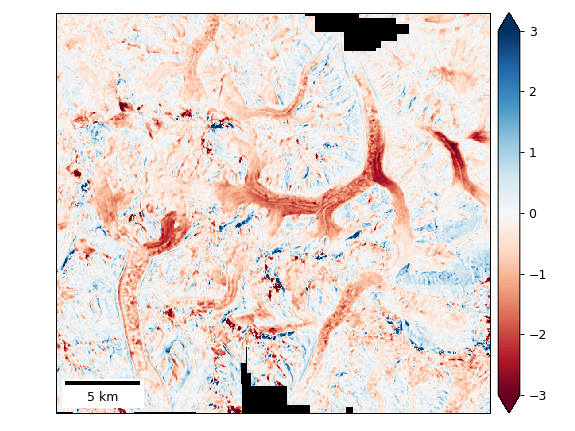

In [11]:
pltlib.iv_ds(ds_list[0],cmap='RdBu',clim=(-3,3))

In [15]:
site_ma = iolib.ds_getma(ds_list[0])

In [12]:
mask_ice = dem_mask.get_icemask(ds_list[0])

Masking glaciers
Found glacier shp: /mnt/Backups/reference_data/data/rgi60/regions/rgi60_merge.shp
Input shp srs: +proj=longlat +datum=WGS84 +no_defs 
Specified output srs: +proj=aea +lat_1=25 +lat_2=47 +lat_0=36 +lon_0=85 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs 


In [18]:
static_ma = np.ma.array(site_ma,mask=~mask_ice)

<IPython.core.display.Javascript object>


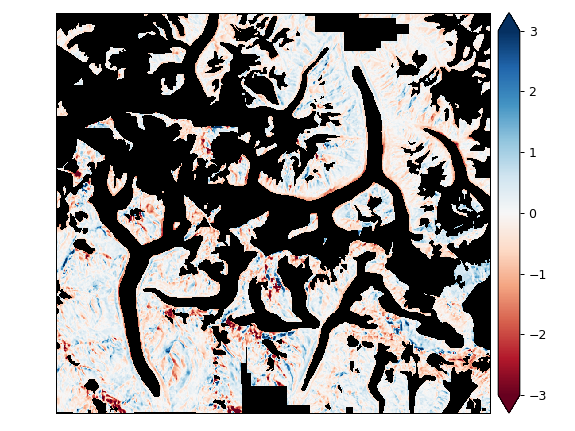

In [19]:
pltlib.iv(static_ma,cmap='RdBu',clim=(-3,3))

In [23]:
df_static = get_xyz(static_ma,ds_list[0].GetGeoTransform(),'dh')
z = 'dh'

In [24]:
df_static.head()

,x,y,dh
0,163823.0,-879800.0,-0.104059
1,163853.0,-879800.0,0.176519
2,163883.0,-879800.0,0.378176
3,166223.0,-879800.0,0.427767
4,166253.0,-879800.0,-0.297654


<IPython.core.display.Javascript object>


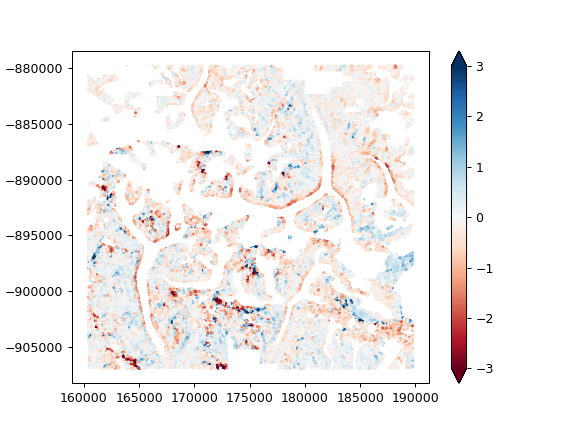

In [25]:
df_static_sample = df_static.sample(n=100000, random_state=1)
fig,ax = plt.subplots()
im = ax.scatter(df_static_sample.x,df_static_sample.y,c=df_static_sample[z],cmap='RdBu',vmin=-3,vmax=3,s=1)
plt.colorbar(im,extend='both')

<IPython.core.display.Javascript object>


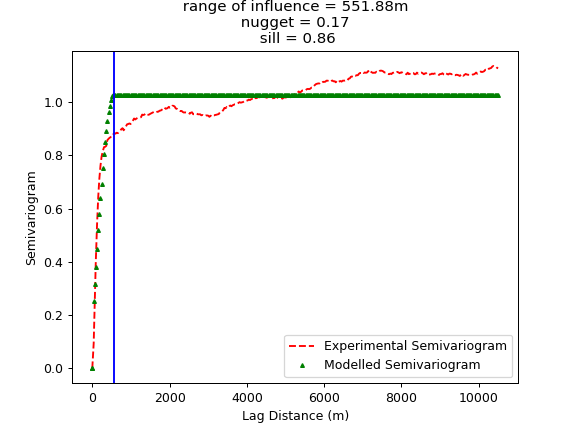

In [26]:
fig,axa = plt.subplots()
z = 'dh'
nlags = 350
lag_dist = 30
lag_mb,gamma_mb,lag_mb_m,gamma_mbm,hrange_mbm,nugget,sill = variogram_wrapper(df_static_sample,z,nlags,lag_dist)
if len(gamma_mbm) <2:
        simple_vario_plt(lag_mb,gamma_mb,z,ax=axa)
else:
    vario_plt_ref(lag_mb,gamma_mb,lag_mb_m,gamma_mbm,hrange_mbm,z,nugget,ax=axa,sill=sill)

## Calculate semivariogram for dhdt_values in 1 km static buffer around glacier

In [28]:
gdf_hma = gpd.read_file('/mnt/Backups/reference_data/data/rgi60/regions/rgi60_merge_HMA_aea.shp')

<IPython.core.display.Javascript object>


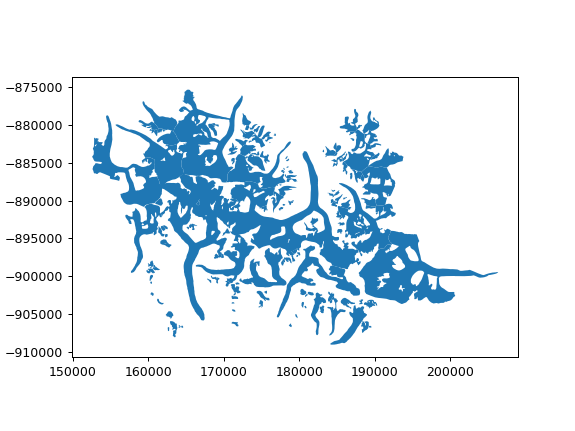

In [29]:
glac_shp_inset = gdf_hma.cx[extent[0]:extent[2], extent[1]:extent[3]]
glac_shp_inset.plot()

In [30]:
#make external buffer
glac_1km_buffer = compute_buffer(glac_shp_inset,1000)

<IPython.core.display.Javascript object>


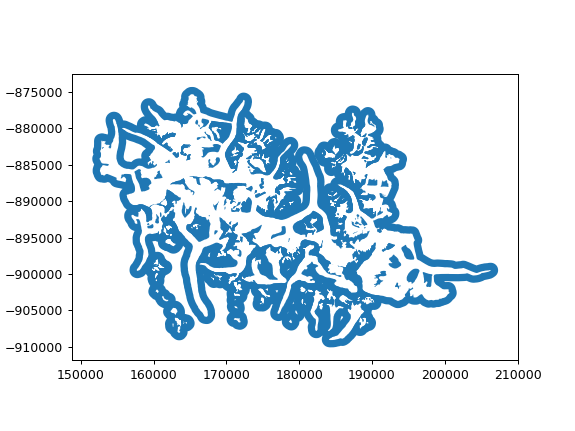

In [31]:
glac_1km_buffer.plot()

<IPython.core.display.Javascript object>


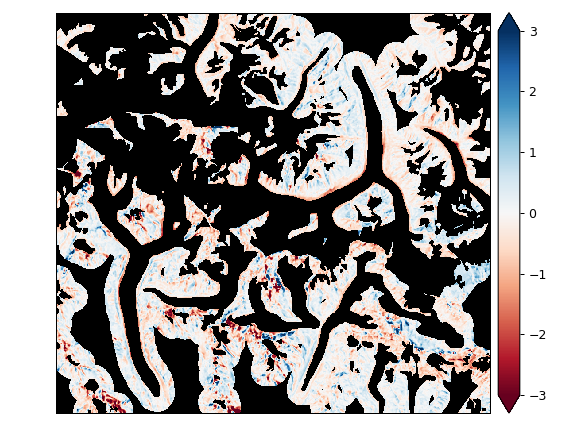

In [33]:
# clip the glacier_static value to buffer and plot
static_1km = mask_by_shp(glac_1km_buffer['geometry'],static_ma,ds_list[0])
pltlib.iv(static_1km,cmap='RdBu',clim=(-3,3))

In [34]:
df_static_buffer = get_xyz(static_1km,ds_list[0].GetGeoTransform(),'dh')

<IPython.core.display.Javascript object>


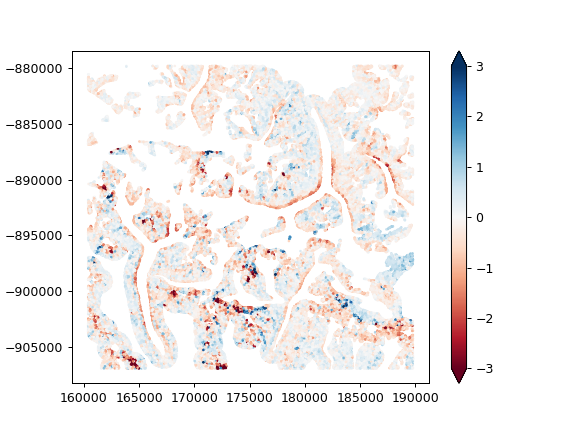

In [35]:
fig,ax = plt.subplots()
z = 'dh'
df_static_buffer_sample = df_static_buffer.sample(n=100000,random_state=1)
im = ax.scatter(df_static_buffer_sample.x,df_static_buffer_sample.y,c=df_static_buffer_sample[z],cmap='RdBu',vmin=-3,vmax=3,s=1)
plt.colorbar(im,extend='both')

<IPython.core.display.Javascript object>


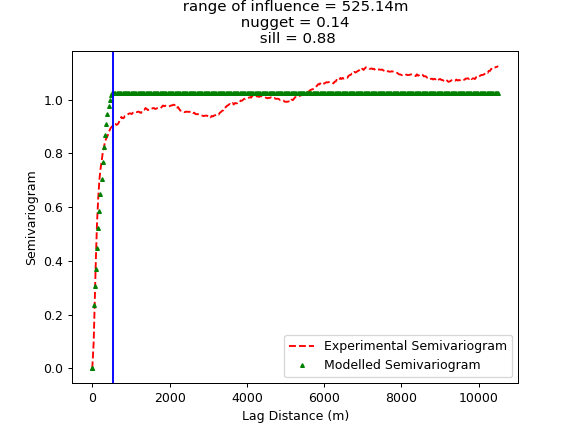

In [36]:
fig,axa = plt.subplots()
#df_bare_sample = df_bare.sample(n=100000, random_state=1)
z = 'dh'
nlags = 350
lag_dist = 30
lag_mb,gamma_mb,lag_mb_m,gamma_mbm,hrange_mbm,nugget,sill = variogram_wrapper(df_static_buffer_sample,z,nlags,lag_dist)
if len(gamma_mbm) <2:
        simple_vario_plt(lag_mb,gamma_mb,z,ax=axa)
else:
    vario_plt_ref(lag_mb,gamma_mb,lag_mb_m,gamma_mbm,hrange_mbm,z,nugget,ax=axa,sill=sill)